In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import tqdm
from collections import namedtuple

In [3]:
import glob, time

In [4]:
from pymono.cnn_fit import fit_coord, plotfxyz

## Functions

In [5]:
def histoplot(var, xlabel, ylabel, bins=100, figsize=(4,4), title=""):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    h = plt.hist(var,bins)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return h[0],h[1]

In [6]:
def prgroup(grdf, ng=1):
    i = 1
    for name, group in grdf:
        print(f"Group: {name}")
        print(group, "\n")
        i+=1
        if i > ng:
            break

In [7]:
def event_ekin(df):
    grdf = df.groupby('event_id')
    ekin = grdf['kin_energy'].sum()
    return ekin

In [8]:
def event_size(df):
    return len(np.unique(df.event_id))

In [9]:
def xindex(x,mcrst, sx):
    return np.floor((x + mcrst.xmin + mcrst.dx)/sx)

def yindex(x,mcrst, sy):
    return np.floor((x + mcrst.ymin + mcrst.dy)/sy)

def zindex(x,mcrst, sz):
    return np.floor((x - mcrst.zmin)/sz)


In [10]:
def voxelize(gdfx,mcrst,i, sx,sy,sz,case='pixel', prnt=10):

    gdf = gdfx.copy()
    nx = int(mcrst.dx/sx)
    ny = int(mcrst.dy/sy)
    nz = int(mcrst.dz/sz)
    
    if i%prnt == 0:
        print(f"nx = {nx}, ny = {ny}, nz = {nz}")
        print(f"number of voxels = {nx*ny*nz}")
        print(f"index for xmin ={xindex(mcrst.xmin, mcrst, sx)} index for xmax ={xindex(mcrst.xmax, mcrst, sx)}")
        print(f"index for ymin ={yindex(mcrst.ymin, mcrst, sy)} index for ymax ={yindex(mcrst.ymax, mcrst, sy)}")
        print(f"index for zmin ={zindex(mcrst.zmin, mcrst, sz)} index for zmax ={zindex(mcrst.zmax, mcrst, sz)}")

    gdf["ix"]= xindex(gdf.x, mcrst, sx).astype(int)
    gdf["iy"]= yindex(gdf.y, mcrst, sy).astype(int)
    gdf["iz"]= zindex(gdf.z, mcrst, sz).astype(int)

    if case == 'pixel':
        grdf = gdf.groupby(['event_id', 'ix', 'iy'])
    else:
         grdf = gdf.groupby(['event_id', 'ix', 'iy', 'iz'])

    # prepare DF to compute baricenter: add columns with xiEi
    gdf = grdf.agg(
                ebox = ('E', 'sum'),
                tbox = ('initial_t', 'first'),     
                x1 = ('x', 'first'),     
                y1 = ('y', 'first'),        
                z1 = ('z', 'first'),        # z in the box is the y mean
                xbox = ('xE', 'sum'),     
                ybox = ('yE', 'sum'),        
                zbox = ('zE', 'sum'),        # z in the box is the y mean
                nbox = ('x', 'count'),  # this counts the number of occurences
                  ).reset_index()
    gdf['xbox'] = gdf['xbox'] / gdf['ebox']
    gdf['ybox'] = gdf['ybox'] / gdf['ebox']
    gdf['zbox'] = gdf['zbox'] / gdf['ebox']
    return gdf

In [11]:
def pixelated(gdfx,mcrst,sx,sy,sz, ecut, case='pixel'):
    gdf = voxelize(gdfx,mcrst,sx,sy,sz, ecut)
    gdf =gdf[gdf.ebox >ecut]
    return event_size(gdf)

In [12]:
def streams(gdx, i, nprnt):
    
    gdf  = gdx.copy()
    grdf = gdf.groupby('event_id')
    gdf  = grdf.agg(#event_id = ('event_id', 'first'),
                etot = ('ebox', 'sum'),
                ngama = ('ebox', 'count')
                  ).reset_index()

    df1g = gdf[gdf.ngama==1]
    df2g = gdf[gdf.ngama==2]
    dfng = gdf[gdf.ngama>2]
    if i%nprnt==0:
        print(f" fraction of events 1g = {(event_size(df1g)/event_size(gdf)):.2f}")
        print(f" fraction of events 2g = {(event_size(df2g)/event_size(gdf)):.2f}")
        print(f" fraction of events >3g = {(event_size(dfng)/event_size(gdf)):.2f}")
    
    return df1g,df2g,dfng
   

In [13]:
def select_gammas_interact_in_crystal(df):
    grdf = df.groupby('event_id')
    return grdf.filter(lambda x: ((x.mother_id == 0) & (x['final_volume'] == 'CRYSTAL')).any() )



In [14]:
def concat_df(file_paths, start=0, end=10):
    DF =[]
    for file in file_paths[start:end]:
        gammas = pd.read_hdf(file,"MC/particles")
        DF.append(gammas.drop(['initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
                 'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
                'final_proc', 'final_t'], axis=1))
                      
    return pd.concat(DF, axis=0)

In [15]:
def compute_xyz(file_paths, start=0, end=10, eth=0.001, lmax=45, bins=100,prnt=10):
    """
    Compute the dimensions of the crystal from the data themselves
    
    """
    def xyz(h):
        zmin = np.ceil(h[0])
        zmax = np.floor(h[-1])
        dz = zmax - zmin
        return zmin, zmax, dz

    def FillXYZ(df, XYZ):               
        h, b = np.histogram(df.initial_z, bins)
        zmin, zmax, dz = xyz(b)          
        
        h, b = np.histogram(df.initial_x, bins)
        xmin, xmax, dx = xyz(b)          
        
        h, b = np.histogram(df.initial_y, bins)
        ymin, ymax, dy = xyz(b)          
        
        XYZ.append(MCrst(xmin, xmax, dx, ymin, ymax, dy, zmin, zmax, dz))


    XYZ = []
    MCrst = namedtuple('MCrst','xmin xmax dx ymin ymax dy zmin zmax dz')
    start_time = time.time()

    for i, file in enumerate(file_paths[start:end]):
        if i%prnt ==0:
            print(f"Reading data frame {i}")
        gammas = pd.read_hdf(file,"MC/particles")

        if i%prnt ==0:
            print(f"Select events in which gammas interact in crystal: time = {time.time() - start_time}")
        gdf1 = select_gammas_interact_in_crystal(gammas)
        
        if i%prnt ==0:
            print(f"Remove primary gammas: time = {time.time() - start_time}")
        gdf2 = gdf1[gdf1['mother_id'] != 0]

        if i%prnt ==0:
            print(f"Remove particles not coming from primaryC") 
        grdf = gdf2.groupby('event_id')
        gdf3 = grdf.apply(lambda x: x[x['mother_id'] == 1]).reset_index(drop=True)

        if i%prnt ==0:
            print(f"Impose threshold in energy and length: time = {time.time() - start_time}") 
        gdf4 = gdf3[(gdf3['kin_energy'] >eth) & (gdf3.length<lmax)]

        FillXYZ(gdf4, XYZ)

    return XYZ

In [16]:
def filter_df(file_paths, start=0, end=10, eth=0.001, lmax=60, prnt=10):
    """
    Filter and reduce the DF
    1. Select events in which gammas interact in crystal
    2. Remove primary gammas
    3. Impose threshold in energy and length
    4. Drop columns not needed, create columns needed for barycenter and rename fields
    5. Concat files
    """

    DF =[]
    start_time = time.time()
    for i, file in enumerate(file_paths[start:end]):
        if i%prnt == 0:
            print(f"Reading data frame {i}")
        gammas = pd.read_hdf(file,"MC/particles")
        gdf1 = gammas.drop(['initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
                 'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
                'final_proc', 'final_t'], axis=1)

        if i%prnt == 0:
            print(f"Select events in which gammas interact in crystal: time = {time.time() - start_time}")
        gdf2 = select_gammas_interact_in_crystal(gdf1)
        
        if i%prnt == 0:
            print(f"Remove primary gammas: time = {time.time() - start_time}")
        gdf3 = gdf2[gdf2['mother_id'] != 0]

        if i%prnt == 0:
            print(f"Remove particles not coming from primaryC") 
        grdf = gdf3.groupby('event_id')
        gdf4 = grdf.apply(lambda x: x[x['mother_id'] == 1]).reset_index(drop=True)

        if i%prnt == 0:
            print(f"Impose threshold in energy and length: time = {time.time() - start_time}") 
        gdf5 = gdf4[(gdf4['kin_energy'] >eth) & (gdf4.length<lmax)]

        if i%prnt == 0:
            print(f"Drop some extra columns and rename fields: time = {time.time() - start_time}") 
        gdf6 = gdf5.drop(['final_x', 'final_y', 'final_z', 'length',
                  'primary', 'mother_id', 'initial_volume', 'final_volume'], axis=1)

        gdf6.rename(columns={'initial_x': 'x'}, inplace=True)
        gdf6.rename(columns={'initial_y': 'y'}, inplace=True)
        gdf6.rename(columns={'initial_z': 'z'}, inplace=True)
        gdf6.rename(columns={'kin_energy': 'E'}, inplace=True)

        if i%prnt == 0:
            print(f"Compute xiEi, yiEi, ziEi = {time.time() - start_time}") 

        gdf6['xE'] = gdf6['x'] * gdf6['E']
        gdf6['yE'] = gdf6['y'] * gdf6['E']
        gdf6['zE'] = gdf6['z'] * gdf6['E']
                
        DF.append(gdf6)

    print(f"now concat: time = {time.time() - start_time}") 
    df = pd.concat(DF, axis=0)

    print(f"after concat: time = {time.time() - start_time}") 
    return df




In [17]:
def filter_and_voxelize_df(file_paths, mcrst, start=0, end=10, eth=0.001, lmax=60, sx=6,sy=6,sz=6, prnt=10):
    """
    Reduce and filter the data frame, the voxelize it. 
    
    """
    
    def event_size(df):
        return len(np.unique(df.event_id))
    
    
    def voxelize(gdfx,mcrst,sx,sy,sz):
        """
        Voxelize the crystal and compute x,y,z,e, & t in each box
        
        """
    
        gdf = gdfx.copy()
        nx = int(mcrst.dx/sx)
        ny = int(mcrst.dy/sy)
        nz = int(mcrst.dz/sz)
        
        gdf["ix"]= xindex(gdf.initial_x, mcrst, sx).astype(int)
        gdf["iy"]= yindex(gdf.initial_y, mcrst, sy).astype(int)
        gdf["iz"]= zindex(gdf.initial_z, mcrst, sz).astype(int)
    
        grdf = gdf.groupby(['event_id', 'ix', 'iy', 'iz'])

        # Elements in the box
        gdf = grdf.agg(
                    e = ('kin_energy', 'sum'),
                    t = ('initial_t', 'first'),     
                    x = ('initial_x', 'first'),     
                    y = ('initial_y', 'first'),        
                    z = ('initial_z', 'first'),        # z in the box is the y mean
                      ).reset_index()
        
        return gdf
        

    def streams(gdx):
        """
        Divide the data in streams
        
        """
    
        gdf  = gdx.copy()
        grdf = gdf.groupby('event_id')
        gdf  = grdf.agg(#event_id = ('event_id', 'first'),
                    ngama = ('e', 'count')
                      ).reset_index()
    
        df1g = gdf[gdf.ngama==1]
        df2g = gdf[gdf.ngama==2]
        dfng = gdf[gdf.ngama>2]
        
        return df1g,df2g,dfng
        
    Event1c =[] 	
    E = []
    X = []
    Y = []
    Z = []
    T = []

    Event2c =[] 	
    E1 = []
    X1 = []
    Y1 = []
    Z1 = []
    T1 = [] 

    E2 = []
    X2 = []
    Y2 = []
    Z2 = []
    T2 = [] 
    ET2 = []

    Eventnc =[]
    Eventt =[]
    Eventg =[]
        
    start_time = time.time()

    for i, file in enumerate(file_paths[start:end]):
        if i%prnt == 0:
            print(f"Reading data frame {i}")
        gammas = pd.read_hdf(file,"MC/particles")

        Eventg.append(event_size(gammas))
        
        gammas.drop(['initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
                 'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
                'final_proc', 'final_t'], axis=1)

        if i%prnt == 0:
            print(f"Select events in which gammas interact in crystal: time = {time.time() - start_time}")
        gdf1 = select_gammas_interact_in_crystal(gammas)
        
        if i%prnt == 0:
            print(f"Remove primary gammas: time = {time.time() - start_time}")
        gdf2 = gdf1[gdf1['mother_id'] != 0]

        if i%prnt == 0:
            print(f"Remove particles not coming from primaryC") 
        grdf = gdf2.groupby('event_id')
        gdf3 = grdf.apply(lambda x: x[x['mother_id'] == 1]).reset_index(drop=True)

        if i%prnt == 0:
            print(f"Impose threshold in energy and length: time = {time.time() - start_time}") 
        gdf4 = gdf3[(gdf3['kin_energy'] >eth) & (gdf3.length<lmax)]

        if i%prnt == 0:
            print(f"Drop some extra columns: time = {time.time() - start_time}") 
        gdf5 = gdf4.drop(['final_x', 'final_y', 'final_z', 'length',
                  'primary', 'mother_id', 'initial_volume', 'final_volume'], axis=1)

        if i%prnt == 0:
            print(f"voxelize: time = {time.time() - start_time}") 
            
        gdm = voxelize(gdf5,mcrst,sx,sy,sz)

        ## Split data into three streams.
        #  Stream 1g: events with 1 cluster: true information: x,y,z,t,e
        #  Stream 2g: events with 2 clusters: true information: x1,y1,z1,t1,e1, x2,y2,z2,t2,e2
        #  Stream ng: events with more than 2 clusters: no true information needed
        df1g,df2g,dfng = streams(gdm)

        gdmx = gdm.drop(['ix', 'iy', 'iz'], axis=1)
        gdm1c = gdmx[gdmx['event_id'].isin(df1g.event_id.values)]
        gdm2c = gdmx[gdmx['event_id'].isin(df2g.event_id.values)]
        gdmnc = gdmx[gdmx['event_id'].isin(dfng.event_id.values)]

        ## Two cluster case
        grdf = gdm2c.groupby('event_id')
        gdy2ca = grdf.agg(#event_id = ('event_id', 'first'),
                etot = ('e', 'sum'),
                e1 = ('e', 'first'),
                e2 = ('e', 'last'),
                x1 = ('x', 'first'),
                x2 = ('x', 'last'),
                y1 = ('y', 'first'),
                y2 = ('y', 'last'),
                z1 = ('z', 'first'),
                z2 = ('z', 'last'),
                t1 = ('t', 'first'),
                t2 = ('t', 'last')
                  ).reset_index()
        
        Event1c.extend(gdm1c.event_id.values) 
        E.extend(gdm1c.e.values) 	
        X.extend(gdm1c.x.values)
        Y.extend(gdm1c.y.values)
        Z.extend(gdm1c.z.values)
        T.extend(gdm1c.t.values)

        Event2c.extend(gdy2ca.event_id.values) 	
        E1.extend(gdy2ca.e1.values) 	
        X1.extend(gdy2ca.x1.values)
        Y1.extend(gdy2ca.y1.values)
        Z1.extend(gdy2ca.z1.values)
        T1.extend(gdy2ca.t1.values)
        E2.extend(gdy2ca.e2.values) 	
        X2.extend(gdy2ca.x2.values)
        Y2.extend(gdy2ca.y2.values)
        Z2.extend(gdy2ca.z2.values)
        T2.extend(gdy2ca.t2.values)
        ET2.extend(gdy2ca.etot.values) 

        Eventnc.extend(gdmnc.event_id.values) 
        Eventt.append(event_size(gdf4))


    # Create composed dfs
    data = {
    'event_id': Event1c,
    'e': E,
    'x': X,
    'y': Y,
    'z': Z,
    't': T
    }
    df1c   = pd.DataFrame(data)

    data = {
    'event_id': Event2c,
    'e1': E1,
    'x1': X1,
    'y1': Y1,
    'z1': Z1,
    't1': T1,
    'e2': E2,
    'x2': X2,
    'y2': Y2,
    'z2': Z2,
    't2': T2,
    'etot': ET2
    }
    df2c   = pd.DataFrame(data)

    data = {
    'event_id': np.unique(np.array(Eventnc))}
    dfnc   = pd.DataFrame(data)
    
    return np.sum(Eventg), np.sum(Eventt), df1c, df2c, dfnc




In [28]:
def mean_XYZ(XYZ):
    XMIN = []
    XMAX = []
    YMIN = []
    YMAX = []
    ZMIN = []
    ZMAX = []
    for xyz in XYZ:
        XMIN.append(xyz.xmin)
        XMAX.append(xyz.xmax)
        YMIN.append(xyz.ymin)
        YMAX.append(xyz.ymax)
        ZMIN.append(xyz.zmin)
        ZMAX.append(xyz.zmax)
        
    xmin = np.ceil(np.mean(np.array(XMIN)))
    xmax = np.floor(np.mean(np.array(XMAX)))
    ymin = np.ceil(np.mean(np.array(YMIN)))
    ymax = np.floor(np.mean(np.array(YMAX)))
    zmin = np.ceil(np.mean(np.array(ZMIN)))
    zmax = np.floor(np.mean(np.array(ZMAX)))
    dx = xmax - xmin
    dy = ymax - ymin
    dz = zmax - zmin
    
    MCrst = namedtuple('MCrst','xmin xmax dx ymin ymax dy zmin zmax dz')
    return MCrst(xmin, xmax, dx, ymin, ymax, dy, zmin, zmax, dz)
        

In [19]:
def compute_deltas(df):
    grdf = df.groupby('event_id')
    DX1 = []
    DY1 = []
    DZ1 = []

    for name, gr in grdf:
        DX1.extend(np.diff(gr.x))
        DY1.extend(np.diff(gr.y))
        DZ1.extend(np.diff(gr.z))

    return np.array(DX1),np.array(DY1),np.array(DZ1)

In [20]:
def plotddx(DX,DY,DZ,bins=100, figsize=(8,8), cut=1.0):
    fig, ax = plt.subplots(2, 3, figsize=figsize)
        
    h00 = ax[0,0].hist(DX,bins)
    ax[0,0].set_xlabel("Dx (mm)")
    ax[0,0].set_ylabel("entries")
    
    h01 = ax[0,1].hist(DY,bins)
    ax[0,1].set_xlabel("Dy (mm)")
    ax[0,1].set_ylabel("entries")
    
    h02 = ax[0,2].hist(DZ,bins)
    ax[0,2].set_xlabel("Dz (mm)")
    ax[0,2].set_ylabel("entries")
    
    h10 = ax[1,0].hist(DX[np.abs(DX)>cut],bins)
    ax[1,0].set_xlabel("Dx1 (mm)")
    ax[1,0].set_ylabel("entries")

    h11 = ax[1,1].hist(DY[np.abs(DY)>cut],bins)
    ax[1,1].set_xlabel("Dy1 (mm)")
    ax[1,1].set_ylabel("entries")
   
    h12 = ax[1,2].hist(DZ[np.abs(DZ)>cut],bins)
    ax[1,2].set_xlabel("Dz1 (mm)")
    ax[1,2].set_ylabel("entries")
    
    fig.tight_layout()
    plt.show()
  

In [21]:
def plotboxd(gdf,bins=100, cut=0.05, figsize=(8,8)):
   
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    dx =gdf.x1 - gdf.xbox
    dy =gdf.y1 - gdf.ybox
    dz =gdf.z1 - gdf.zbox
    
    h00 = ax[0,0].hist(dx[np.abs(dx)>cut],bins)
    ax[0,0].set_xlabel("Dx (mm)")
    ax[0,0].set_ylabel("entries")
    
    h01 = ax[0,1].hist(dy[np.abs(dy)>cut],bins)
    ax[0,1].set_xlabel("Dy (mm)")
    ax[0,1].set_ylabel("entries")
    
    h02 = ax[1,0].hist(dz[np.abs(dz)>cut],bins)
    ax[1,0].set_xlabel("Dz (mm)")
    ax[1,0].set_ylabel("entries")
    
    h10 = ax[1,1].hist(dx,bins)
    ax[1,1].set_xlabel("Dx1 (mm)")
    ax[1,1].set_ylabel("entries")
    
    fig.tight_layout()
    plt.show()

## Code

In [24]:
path_to_data=os.environ['MONOLITH_DATA'] 
npr=10
eth = 0.001 # in keV
lmax = 50 # in mm
dir = os.path.join(path_to_data,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5")
# Define the pattern to match all .txt files in the 'documents' directory
pattern = f'{dir}/*.h5'

# Use glob to find all files matching the pattern
file_paths = glob.glob(pattern)



In [25]:
len(file_paths)

100

### Compute crystal dimensions

In [26]:
XYZ = compute_xyz(file_paths, start=0, end=5, eth=0.001, lmax=45, bins=100, prnt=100)

Reading data frame 0
Select events in which gammas interact in crystal: time = 1.2319538593292236
Remove primary gammas: time = 2.044407606124878
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 3.7379841804504395


In [29]:
xyzc = mean_XYZ(XYZ)

In [30]:
xyzc

MCrst(xmin=-23.0, xmax=23.0, dx=46.0, ymin=-23.0, ymax=23.0, dy=46.0, zmin=13.0, zmax=50.0, dz=37.0)

##  Filter and reduce the DF
    1. Select events in which gammas interact in crystal
    2. Remove primary gammas
    3. Impose threshold in energy and length
    4. Drop columns not needed, create columns needed for barycenter and rename fields
    5. Concat files

In [319]:
gdf = filter_df(file_paths, start=0, end=5, eth=0.001, lmax=50, prnt=5)

Reading data frame 0
Select events in which gammas interact in crystal: time = 0.05504179000854492
Remove primary gammas: time = 0.9693553447723389
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 2.434596300125122
Drop some extra columns and rename fields: time = 2.4356274604797363
Compute xiEi, yiEi, ziEi = 2.4363386631011963
now concat: time = 12.151625394821167
after concat: time = 12.15335488319397


In [320]:
gdf.columns

Index(['event_id', 'particle_id', 'particle_name', 'x', 'y', 'z', 'initial_t',
       'E', 'creator_proc', 'xE', 'yE', 'zE'],
      dtype='object')

In [322]:
gdf.head(10)

,event_id,particle_id,particle_name,x,y,z,initial_t,E,creator_proc,xE,yE,zE
0,680002,2,e-,17.471272,-21.407799,15.194095,0.070294,0.212338,compt,3.709820,-4.545696,3.226288
1,680002,25621,e-,16.308014,-8.935721,20.914680,0.116228,0.002909,compt,0.047434,-0.025991,0.060833
2,680002,26109,e-,15.823273,-6.602371,22.563520,0.125894,0.003268,phot,0.051706,-0.021575,0.073731
3,680002,26108,e-,15.823273,-6.602371,22.563520,0.125894,0.003892,phot,0.061591,-0.025699,0.087827
4,680002,26107,e-,15.823273,-6.602371,22.563520,0.125894,0.025294,phot,0.400234,-0.167000,0.570722
5,680002,26106,e-,15.823273,-6.602371,22.563520,0.125894,0.258608,phot,4.092019,-1.707424,5.835098
6,680005,3,e-,6.790020,7.181014,32.762108,0.128651,0.005044,compt,0.034246,0.036218,0.165239
7,680005,2,e-,6.790020,7.181014,32.762108,0.128651,0.222331,compt,1.509632,1.596563,7.284034
8,680005,27589,e-,15.265637,4.257829,35.750702,0.160174,0.080053,compt,1.222063,0.340853,2.861958
9,680005,37070,e-,18.203693,2.432415,30.927778,0.179971,0.003284,phot,0.059776,0.007987,0.101558


### Compute the flight distance of e- in crystal

In [325]:
DX,DY,DZ = compute_deltas(gdf)

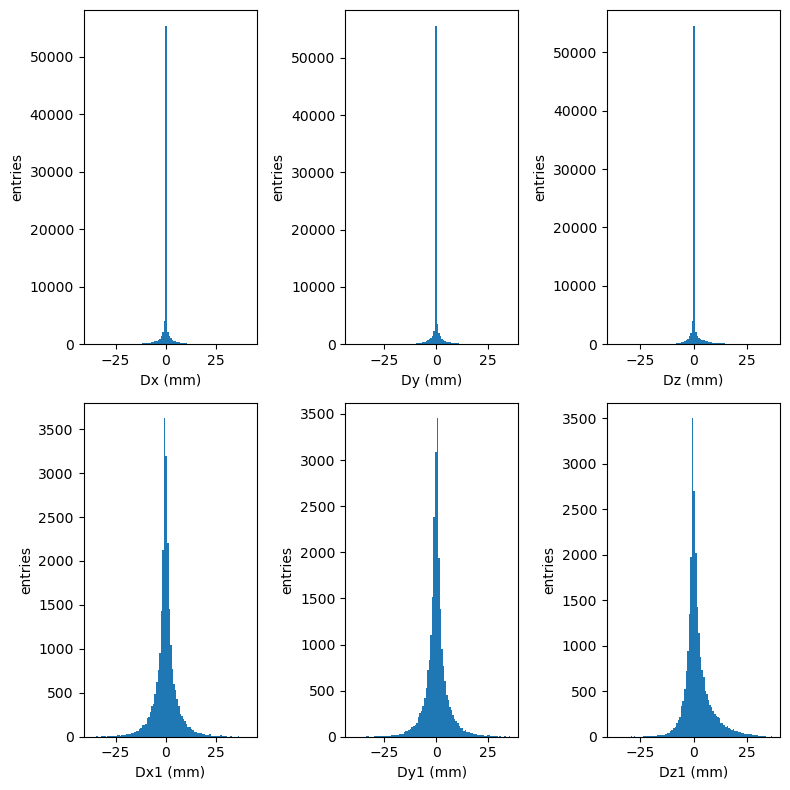

In [327]:
plotddx(DX,DY,DZ,bins=100, figsize=(8,8), cut=0.1)

In [329]:
f2gz, f2gx, f2gy = fit_coord(DX[np.abs(DX)>0.1], DY[np.abs(DY)>0.1], DZ[np.abs(DZ)>0.1], bins=100)

2g fit: mu1 = -0.19, sigma = 0.94, n1  =0.69
2g fit: mu2 = 1.00, sigma = 4.67, n1  =0.31
weighted error: = 2.10
2g fit: mu1 = 0.08, sigma = 4.80, n1  =0.28
2g fit: mu2 = -0.09, sigma = 1.03, n1  =0.72
weighted error: = 2.09
2g fit: mu1 = 0.08, sigma = 1.04, n1  =0.70
2g fit: mu2 = -0.09, sigma = 4.66, n1  =0.30
weighted error: = 2.12


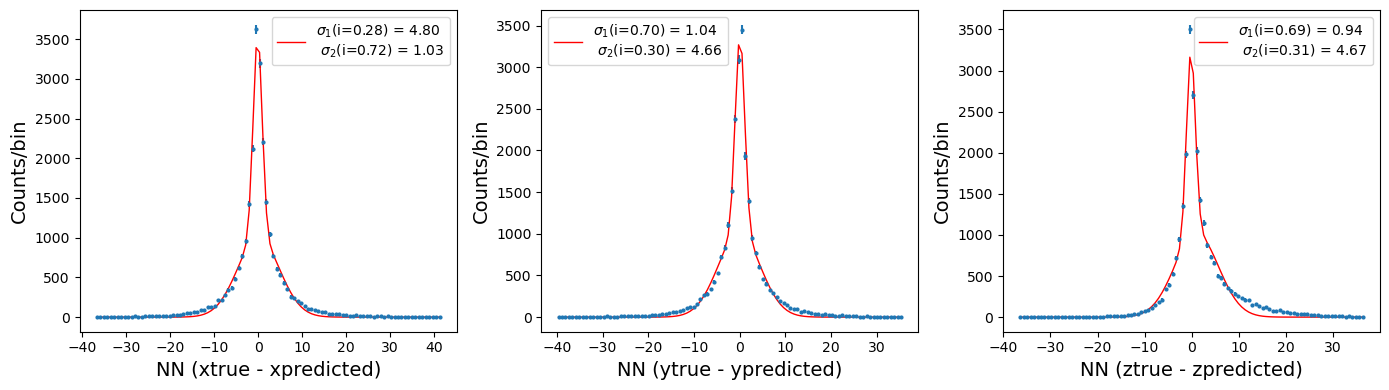

In [330]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

#### Flight distance
- In all coordinates, after cutoff (which eliminates low energy tracks) two components (70/30), at ~1 mm and ~5 mm. 

## Voxelize crystal (9mm)

In [351]:
gdfb = voxelize(gdf,xyzc,1, sx=9,sy=9,sz=9,case='mono', prnt=1)

nx = 5, ny = 5, nz = 4
number of voxels = 100
index for xmin =0.0 index for xmax =5.0
index for ymin =0.0 index for ymax =5.0
index for zmin =0.0 index for zmax =4.0


In [352]:
gdfb

,event_id,ix,iy,iz,ebox,tbox,x1,y1,z1,xbox,ybox,zbox,nbox
0,80000,1,3,1,0.267142,0.164965,-6.468779,6.699799,30.230259,-6.468779,6.699799,30.230259,1
1,80000,2,3,1,0.020861,0.157675,-4.326902,6.266281,30.262753,-4.326902,6.266281,30.262754,1
2,80000,3,2,1,0.221678,0.111498,5.410841,-2.503098,27.528318,5.466898,-2.214287,27.972820,2
3,80001,5,1,2,0.480867,0.148258,23.959150,-6.985072,38.808884,23.959150,-6.985072,38.808884,2
4,80002,1,2,0,0.508781,0.079224,-5.889712,-4.328921,17.513109,-5.889712,-4.328921,17.513107,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40933,977810,0,1,1,0.509517,0.102208,-22.131554,-10.525648,24.818983,-22.131552,-10.525648,24.818983,3
40934,977812,1,2,1,0.229196,0.222152,-13.785409,-4.431967,27.472837,-13.785410,-4.431967,27.472839,3
40935,977812,3,3,2,0.280461,0.144201,5.510693,4.452209,37.211765,5.510693,4.452209,37.211765,1
40936,977813,3,0,3,0.093998,0.168708,5.160706,-20.914318,44.562244,5.160706,-20.914318,44.562244,1


### Difference between barycenter (xbox) and first interaction (x1)

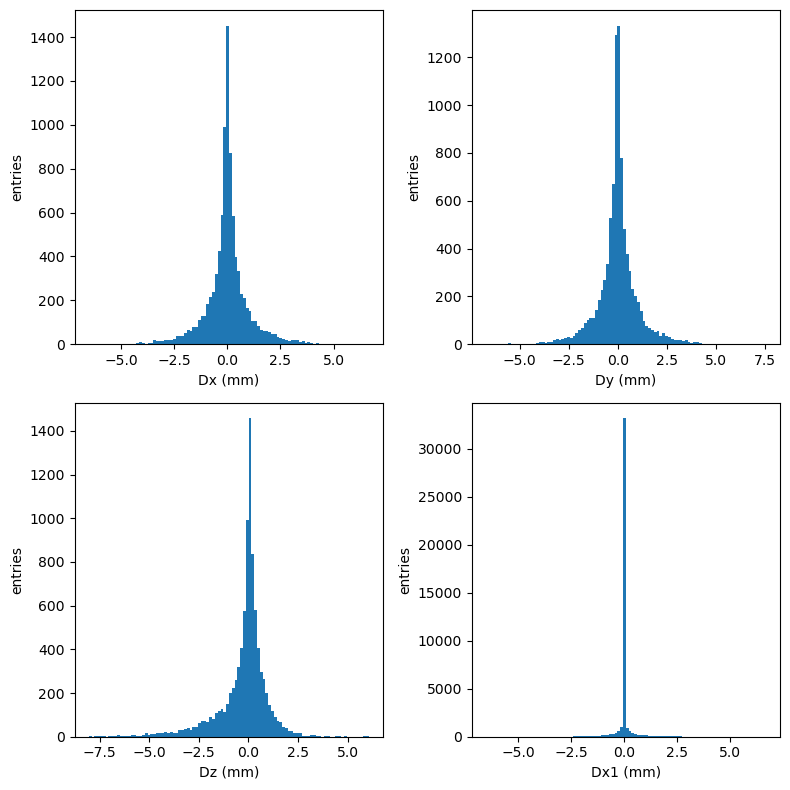

In [353]:
plotboxd(gdfb,bins=100, cut=0.01, figsize=(8,8))

In [354]:
dx =gdfb.x1 - gdfb.xbox
dy =gdfb.y1 - gdfb.ybox
dz =gdfb.z1 - gdfb.zbox
f2gz, f2gx, f2gy = fit_coord(dz[np.abs(dz)>0.01], dx[np.abs(dx)>0.01], dy[np.abs(dy)>0.01], bins=100)

2g fit: mu1 = -0.00, sigma = 0.83, n1  =0.29
2g fit: mu2 = -0.01, sigma = 0.15, n1  =0.71
weighted error: = 0.35
2g fit: mu1 = 0.02, sigma = 0.81, n1  =0.30
2g fit: mu2 = 0.06, sigma = 0.13, n1  =0.70
weighted error: = 0.33
2g fit: mu1 = -0.00, sigma = 0.13, n1  =0.70
2g fit: mu2 = 0.00, sigma = 0.77, n1  =0.30
weighted error: = 0.32


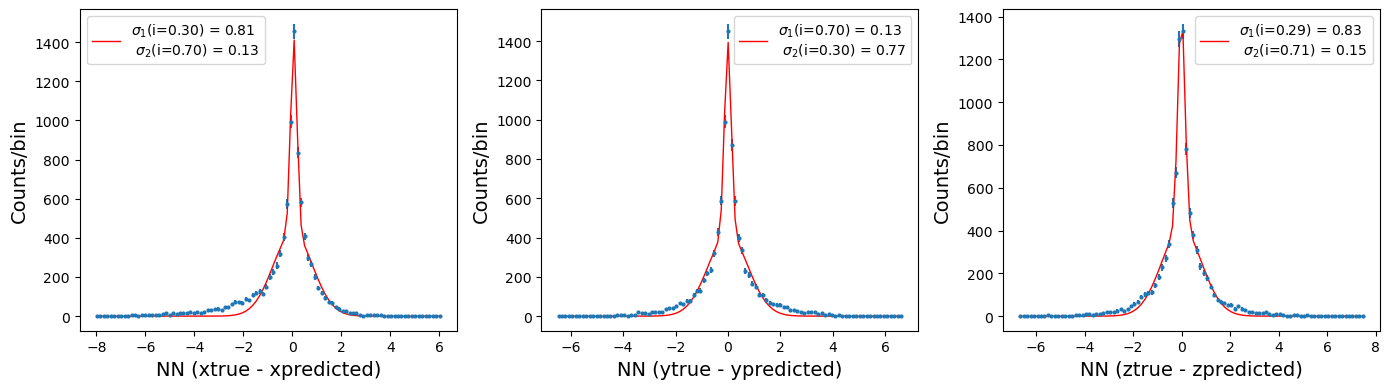

In [355]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

#### x1 -xbox
- In all coordinates, after cutoff (which eliminates low energy tracks) two components (70/30), at ~0.3 mm and ~1.5 mm. 

In [356]:
 df1c, df2c, dfnc =streams(gdfb, 1, 1)

 fraction of events 1g = 0.53
 fraction of events 2g = 0.36
 fraction of events >3g = 0.11


## Voxelize at 6 mm

In [357]:
gdfb = voxelize(gdf,xyzc,1, sx=6,sy=6,sz=6,case='mono', prnt=1)

nx = 7, ny = 7, nz = 6
number of voxels = 294
index for xmin =0.0 index for xmax =7.0
index for ymin =0.0 index for ymax =7.0
index for zmin =0.0 index for zmax =6.0


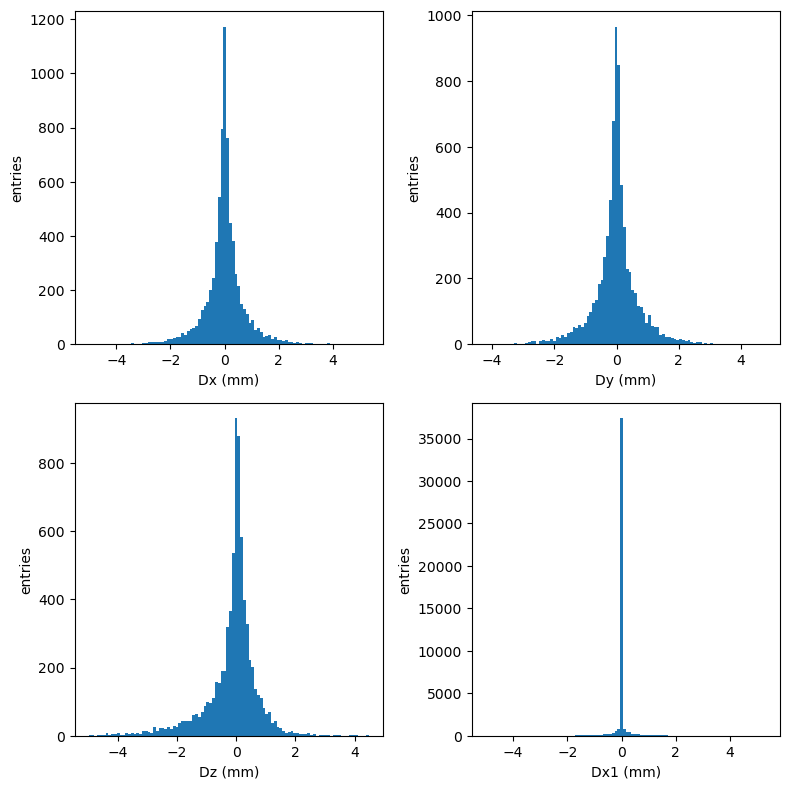

In [358]:
plotboxd(gdfb,bins=100, cut=0.01, figsize=(8,8))

In [359]:
dx =gdfb.x1 - gdfb.xbox
dy =gdfb.y1 - gdfb.ybox
dz =gdfb.z1 - gdfb.zbox
f2gz, f2gx, f2gy = fit_coord(dz[np.abs(dz)>0.01], dx[np.abs(dx)>0.01], dy[np.abs(dy)>0.01], bins=100)

2g fit: mu1 = -0.01, sigma = 0.64, n1  =0.28
2g fit: mu2 = 0.00, sigma = 0.12, n1  =0.72
weighted error: = 0.26
2g fit: mu1 = 0.04, sigma = 0.12, n1  =0.70
2g fit: mu2 = 0.01, sigma = 0.65, n1  =0.30
weighted error: = 0.28
2g fit: mu1 = 0.00, sigma = 0.54, n1  =0.33
2g fit: mu2 = -0.00, sigma = 0.10, n1  =0.67
weighted error: = 0.25


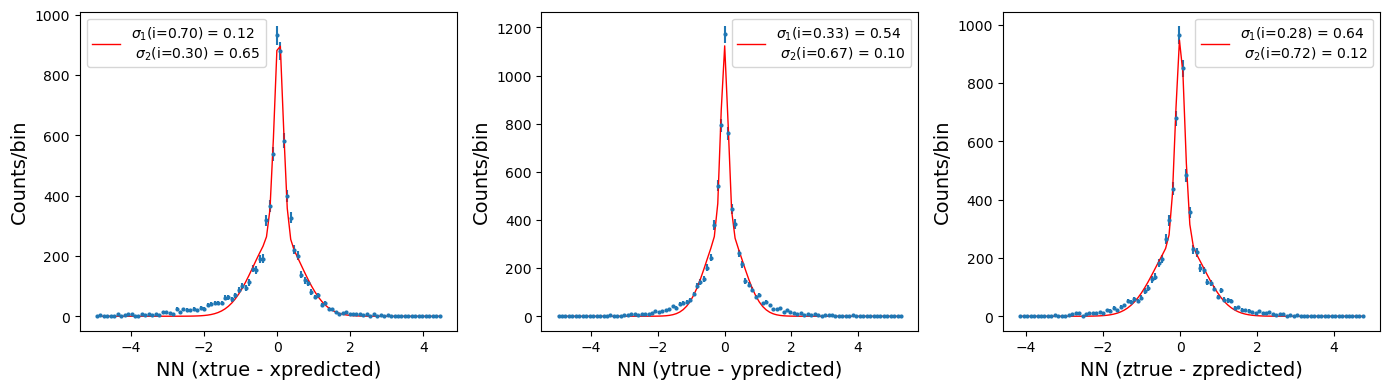

In [360]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

In [361]:
df1c, df2c, dfnc =streams(gdfb, 1, 1)

 fraction of events 1g = 0.47
 fraction of events 2g = 0.38
 fraction of events >3g = 0.15


## Voxelize at 3 mm

In [362]:
gdfb = voxelize(gdf,xyzc,1, sx=3,sy=3,sz=3,case='mono', prnt=1)

nx = 15, ny = 15, nz = 12
number of voxels = 2700
index for xmin =0.0 index for xmax =15.0
index for ymin =0.0 index for ymax =15.0
index for zmin =0.0 index for zmax =12.0


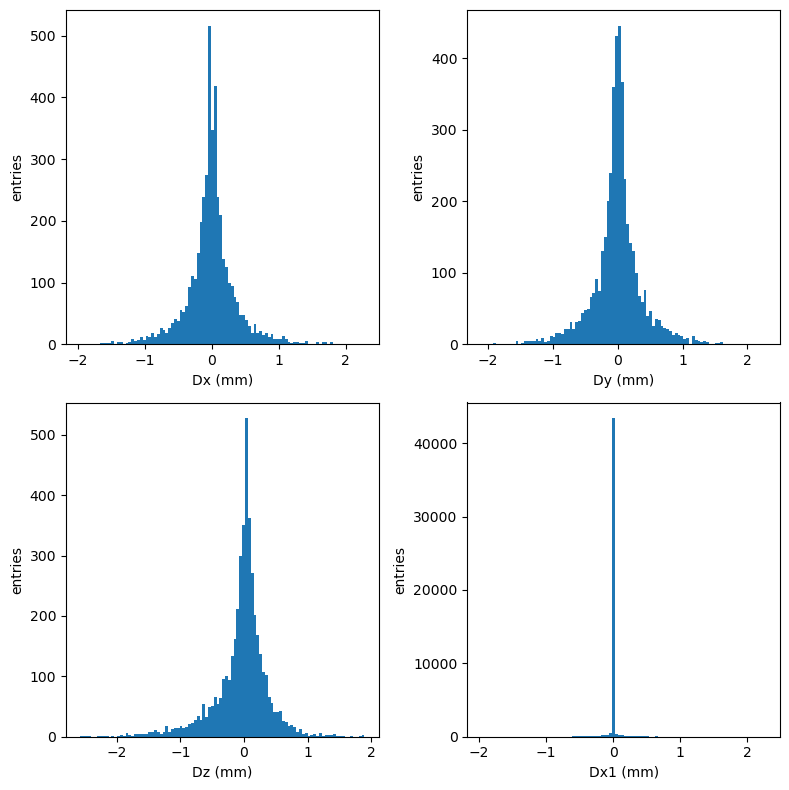

In [363]:
plotboxd(gdfb,bins=100, cut=0.01, figsize=(8,8))

In [364]:
dx =gdfb.x1 - gdfb.xbox
dy =gdfb.y1 - gdfb.ybox
dz =gdfb.z1 - gdfb.zbox
f2gz, f2gx, f2gy = fit_coord(dz[np.abs(dz)>0.01], dx[np.abs(dx)>0.01], dy[np.abs(dy)>0.01], bins=100)

2g fit: mu1 = 0.00, sigma = 0.08, n1  =0.71
2g fit: mu2 = -0.01, sigma = 0.37, n1  =0.29
weighted error: = 0.17
2g fit: mu1 = 0.04, sigma = 0.07, n1  =0.67
2g fit: mu2 = 0.01, sigma = 0.35, n1  =0.33
weighted error: = 0.16
2g fit: mu1 = -0.01, sigma = 0.34, n1  =0.32
2g fit: mu2 = -0.01, sigma = 0.08, n1  =0.68
weighted error: = 0.16


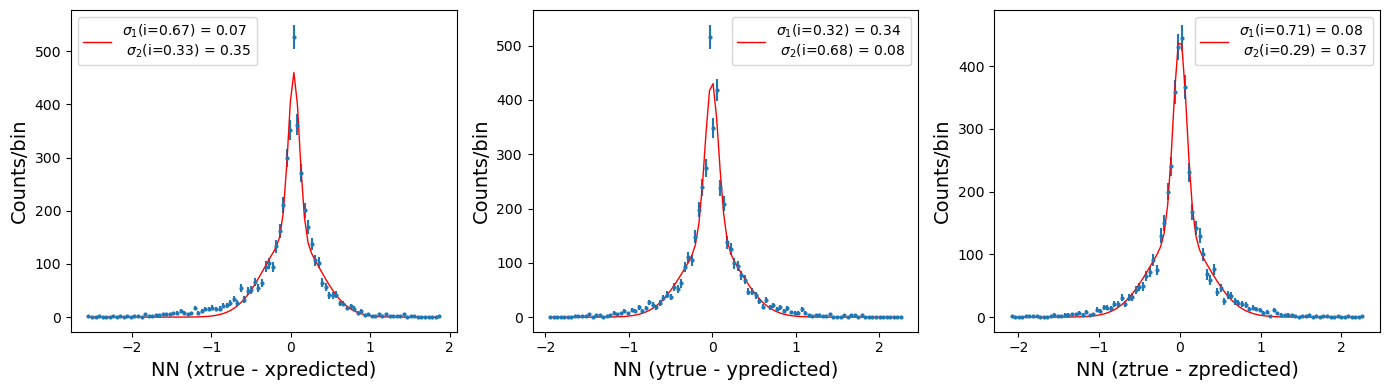

In [365]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

In [366]:
df1c, df2c, dfnc =streams(gdfb, 1, 1)

 fraction of events 1g = 0.41
 fraction of events 2g = 0.39
 fraction of events >3g = 0.20


In [388]:
ntot, nint, df1c, df2c, dfnc =filter_and_voxelize_df(file_paths, xyzc, start=0, end=100, eth=0.001, lmax=50, sx=6,sy=6,sz=6, prnt=10)

Reading data frame 0
Select events in which gammas interact in crystal: time = 0.055710792541503906
Remove primary gammas: time = 1.0714912414550781
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 3.249882459640503
Drop some extra columns: time = 3.2511119842529297
voxelize: time = 3.251674175262451
Reading data frame 10
Select events in which gammas interact in crystal: time = 30.24405002593994
Remove primary gammas: time = 31.24342632293701
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 33.43172264099121
Drop some extra columns: time = 33.43363809585571
voxelize: time = 33.434815883636475
Reading data frame 20
Select events in which gammas interact in crystal: time = 60.76992630958557
Remove primary gammas: time = 61.7760694026947
Remove particles not coming from primaryC
Impose threshold in energy and length: time = 63.95500612258911
Drop some extra columns: time = 63.95698809623718
voxelize: time = 63.

In [390]:
print(f"total events = {ntot}, gamma interact in crystal = {nint}")
print(f" fraction of interacting events 1g = {(event_size(df1c)/nint):.2f}")
print(f" fraction of interacting events 2g = {(event_size(df2c)/nint):.2f}")
print(f" fraction of interacting events >2g = {(event_size(dfnc)/nint):.2f}")

total events = 780977, gamma interact in crystal = 512770
 fraction of interacting events 1g = 0.48
 fraction of interacting events 2g = 0.37
 fraction of interacting events >2g = 0.15


In [391]:
df1c.head(10)

,event_id,e,x,y,z,t
0,680009,0.509477,22.980526,-13.199500,21.642168,0.092036
1,680013,0.509532,7.952593,11.638771,23.469316,0.097319
2,680014,0.509908,7.364207,4.223968,32.475761,0.130219
3,680016,0.510118,18.515432,11.623202,25.020212,0.104700
4,680017,0.510118,18.593311,22.155993,17.614016,0.077718
5,680021,0.509517,-20.236845,10.469377,18.263418,0.082454
6,680028,0.509740,-5.007498,-4.708923,16.299467,0.073695
7,680035,0.510299,18.167727,14.800977,32.894970,0.129985
8,680036,0.509898,-0.569857,-12.751747,14.563081,0.069521
9,680045,0.509517,-3.599593,-12.073962,48.699757,0.181539


In [392]:
df2c.head(10)

,event_id,e1,x1,y1,z1,t1,e2,x2,y2,z2,t2,etot
0,680002,0.212338,17.471272,-21.407799,15.194095,0.070294,0.293970,16.308014,-8.935721,20.914680,0.116228,0.506309
1,680012,0.490189,7.399758,5.527799,37.452305,0.145619,0.019457,7.774612,9.284460,24.312502,0.100016,0.509646
2,680015,0.265192,-11.393455,-4.087695,29.447952,0.136485,0.241611,-5.289300,-2.243407,27.823009,0.114535,0.506803
3,680019,0.373082,5.149138,-20.993856,17.064625,0.078688,0.134196,7.510754,-22.392363,15.305489,0.091319,0.507278
4,680020,0.212166,-17.858292,12.359214,14.139738,0.067111,0.296383,-13.599616,14.759253,15.505701,0.084042,0.508549
5,680023,0.299482,-13.707857,8.481172,34.774075,0.137684,0.206885,-8.139427,11.710300,37.158585,0.162855,0.506367
6,680026,0.305249,2.738029,17.115707,25.573988,0.106109,0.201400,4.139756,23.858950,20.412182,0.134819,0.506649
7,680027,0.307370,-19.053232,-1.298878,30.259762,0.188756,0.202413,4.581564,-13.742261,22.622988,0.096089,0.509783
8,680029,0.227381,-10.441017,6.501498,15.108518,0.070536,0.282553,-5.217257,18.462250,18.139032,0.115683,0.509934
9,680030,0.166262,8.890660,-0.960924,21.336874,0.129725,0.343549,9.875031,1.586962,26.683365,0.109698,0.509810


In [393]:
dfnc.head(10)

,event_id
0,10001
1,10010
2,10020
3,10039
4,10049
5,10118
6,10141
7,10143
8,10149
9,10150


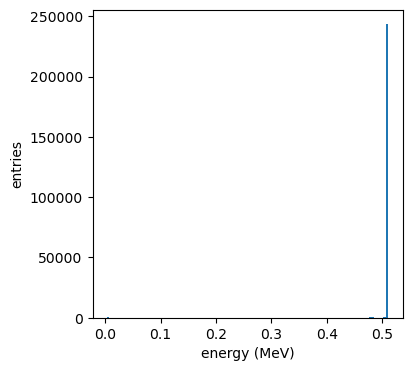

In [394]:
b, e = histoplot(df1c.e, 'energy (MeV)', "entries", bins=100, figsize=(4,4))

In [395]:
def plotd1c(bins=100, figsize=(8,8)):
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    _ = ax[0,0].hist(df1c.x,bins)
    ax[0,0].set_xlabel("x (mm)")
    ax[0,0].set_ylabel("entries")
    #ax[0,0].set_title("x")
    _ = ax[0,1].hist(df1c.y,bins)
    ax[0,1].set_xlabel("y (mm)")
    ax[0,1].set_ylabel("entries")
    _ = ax[1,0].hist(df1c.z,bins)
    ax[1,0].set_xlabel("z (mm)")
    ax[1,0].set_ylabel("entries")
    _ = ax[1,1].hist(df1c.t,bins)
    ax[1,1].set_xlabel("t (ns)")
    ax[1,1].set_ylabel("entries")
    
    fig.tight_layout()
    plt.show()

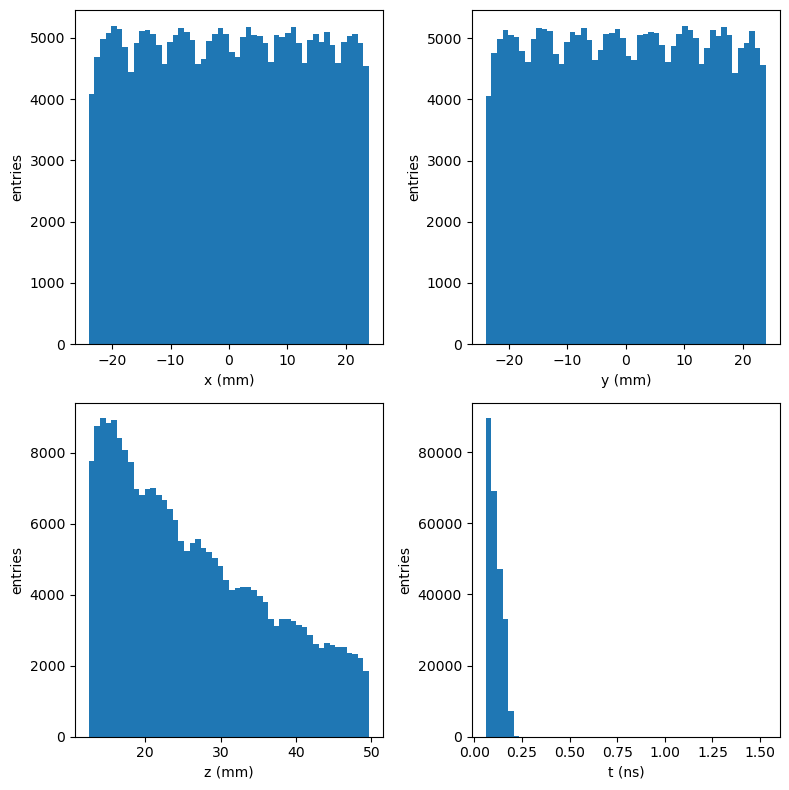

In [396]:
plotd1c(bins=50, figsize=(8,8))

Text(0, 0.5, 'e2 (mm)')

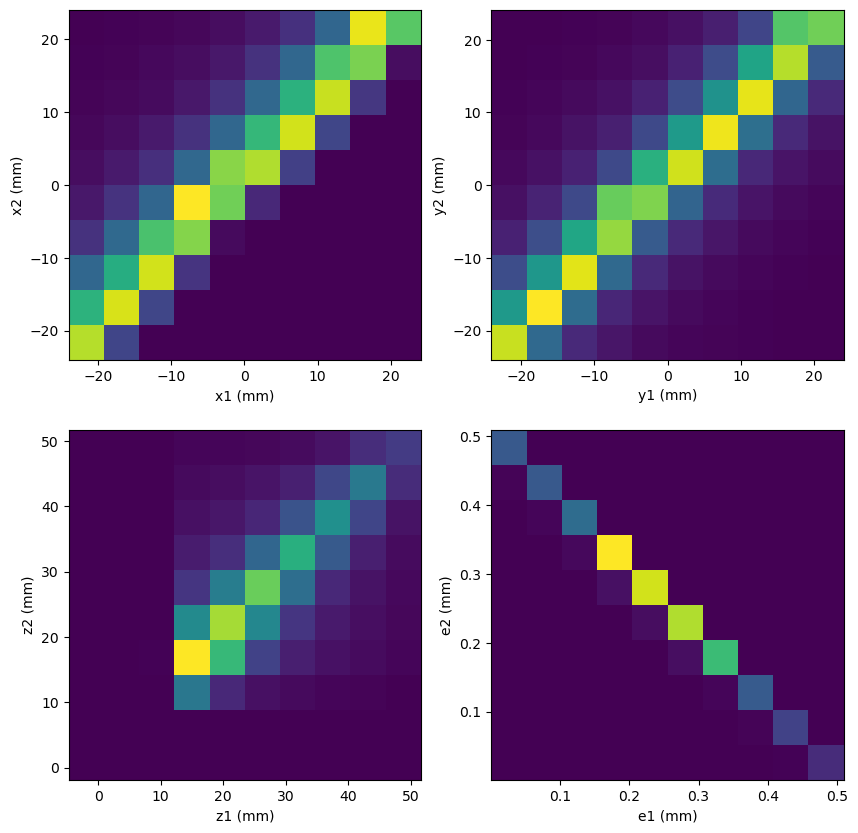

In [397]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

hxy =ax[0,0].hist2d(df2c.x1, df2c.x2, cmap="viridis",bins=10)
#ax[0].set_aspect('equal')
ax[0,0].set_xlabel('x1 (mm)')
ax[0,0].set_ylabel('x2 (mm)')

hxz =ax[0,1].hist2d(df2c.y1, df2c.y2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[0,1].set_xlabel('y1 (mm)')
ax[0,1].set_ylabel('y2 (mm)')

hxz =ax[1,0].hist2d(df2c.z1, df2c.z2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,0].set_xlabel('z1 (mm)')
ax[1,0].set_ylabel('z2 (mm)')

hxz =ax[1,1].hist2d(df2c.e1, df2c.e2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,1].set_xlabel('e1 (mm)')
ax[1,1].set_ylabel('e2 (mm)')

In [398]:
def distance():
    return np.sqrt((df2c.x1 - df2c.x2)**2 + (df2c.y1 - df2c.y2)**2 + (df2c.z1 - df2c.z2)**2)

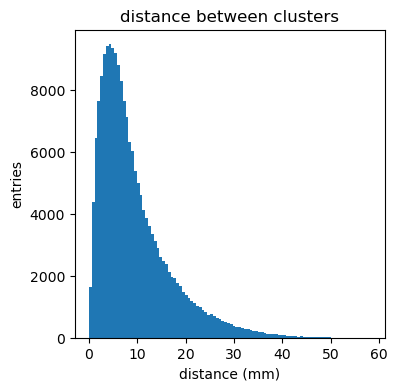

In [399]:
h = histoplot(distance(), "distance (mm)", "entries", bins=100, figsize=(4,4), title="distance between clusters")

In [400]:
df1c.to_csv('df1c.csv', index=False)

In [401]:
df2c.to_csv('df2c.csv', index=False)

In [402]:
dfnc.to_csv('dfnc.csv', index=False)

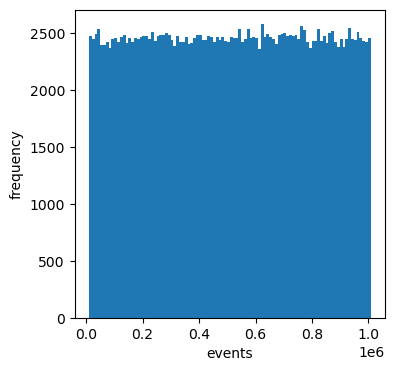

In [412]:
h = histoplot(df1c.event_id, "events", "frequency", bins=100, figsize=(4,4), title="")

In [413]:
df1cs =df1c.sort_values(by='event_id')

df1cs

,event_id,e,x,y,z,t
63683,10004,0.510118,18.645067,12.477487,29.249544,0.116340
63684,10006,0.509274,13.566376,1.647984,21.156849,0.090734
63685,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
63686,10018,0.508170,-22.957691,-9.322307,45.483715,0.171747
63687,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
...,...,...,...,...,...,...
14600,1007799,0.508742,-23.166395,-11.359650,14.579615,0.067818
14601,1007800,0.508591,4.881050,-3.706980,32.271664,0.126875
14602,1007802,0.509488,-13.702808,23.185465,30.448406,0.123165
14603,1007804,0.509248,-9.634733,17.533094,17.117769,0.076375


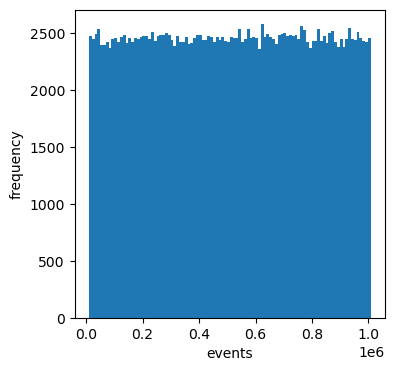

In [414]:
h = histoplot(df1cs.event_id, "events", "frequency", bins=100, figsize=(4,4), title="")

In [417]:
df2cs =df2c.sort_values(by='event_id')
df2cs

,event_id,e1,x1,y1,z1,t1,e2,x2,y2,z2,t2,etot
49899,10003,0.330298,4.990294,0.311470,16.939791,0.091601,0.179934,11.767439,1.126573,13.503364,0.066109,0.510232
49900,10009,0.322141,9.770208,10.759822,43.035156,0.164733,0.186507,12.210072,15.519191,37.142849,0.191277,0.508648
49901,10013,0.265549,6.276037,13.364479,40.609715,0.156441,0.244618,21.409986,-10.269456,37.568260,0.250601,0.510166
49902,10017,0.178680,10.950835,11.677908,17.862885,0.091082,0.329565,13.083003,7.918981,15.518206,0.072993,0.508245
49903,10019,0.130845,3.697574,-9.119902,20.059361,0.088333,0.378074,4.120632,-2.767935,25.876673,0.117098,0.508920
...,...,...,...,...,...,...,...,...,...,...,...,...
11675,1007784,0.390166,-20.912951,-20.125721,30.411863,0.123065,0.118979,-19.904688,-16.910192,27.752243,0.140103,0.509145
11676,1007789,0.268718,6.582607,-13.995539,15.066959,0.070758,0.241255,7.014958,-14.208030,15.030254,0.072369,0.509973
11677,1007797,0.303024,-7.403781,-23.204754,49.368690,0.184981,0.206537,-4.950836,-21.901775,47.709839,0.195792,0.509561
11678,1007798,0.088578,-14.235914,12.100848,19.425718,0.084616,0.420159,-0.171507,15.589924,37.255890,0.161256,0.508737


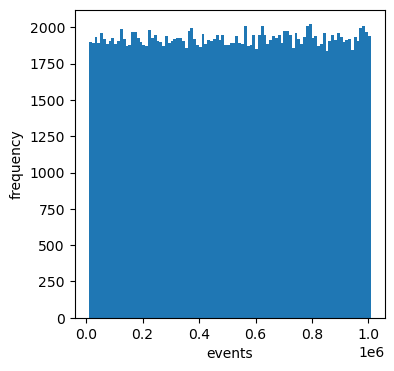

In [418]:
h = histoplot(df2cs.event_id, "events", "frequency", bins=100, figsize=(4,4), title="")

In [420]:
dfncs =dfnc.sort_values(by='event_id')
dfncs

,event_id
0,10001
1,10010
2,10020
3,10039
4,10049
...,...
74667,1007756
74668,1007766
74669,1007770
74670,1007786


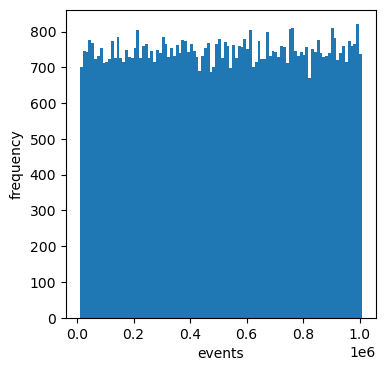

In [421]:
h = histoplot(dfncs.event_id, "events", "frequency", bins=100, figsize=(4,4), title="")